In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7, 7)
plt.set_cmap("viridis")

import itertools
import numpy as np

In [21]:
def vectorize(func):
    def wrapper(x):
        v = np.zeros(len(x))
        for i, x_i in enumerate(x):
            v[i] = func(x_i)
        return v.reshape(-1, 1)
    return wrapper

In [ ]:
from carl.distributions import Normal
from carl.data import GK

true_A = 3.
true_B = 1.5
true_g = 2.
true_k = 0.5

gk = GK(A=true_A, B=true_B, g=true_g, k=true_k)
X_true = gk.rvs(10000)
p1 = Normal(mu=np.mean(X_true), sigma=np.std(X_true) * 4)

In [ ]:
from carl.learning import as_classifier
from carl.learning import make_parameterized_classification
from carl.learning import ParameterizedClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Build classification data
X, y = make_parameterized_classification(
    gk, p1, 100000, 
    [(gk.A, np.linspace(1, 5, num=20)), 
     (gk.B, np.linspace(1, 5, num=20)),
     (gk.g, np.linspace(1, 5, num=20))])

# Train parameterized classifier
clf = ParameterizedClassifier(
    make_pipeline(StandardScaler(), 
                  as_classifier(MLPRegressor(learning_rate="adaptive", 
                                             hidden_layer_sizes=(100, 100)))),
    [gk.A, gk.B, gk.g])
clf.fit(X, y)

In [31]:
from GPyOpt.methods import BayesianOptimization

from carl.learning import CalibratedClassifierCV
from carl.ratios import ClassifierRatio

def objective(theta, random_state=0): 
    print(theta)
    # Set parameter values
    gk.set_params(random_state=random_state)
    p1.set_params(random_state=random_state+1)
    gk.A.set_value(theta[0])
    gk.B.set_value(theta[1])
    
    def objective_g(g):
        gk.g.set_value(g[0])

        # Fit ratio
        ratio = ClassifierRatio(CalibratedClassifierCV(
            base_estimator=clf, 
            cv="prefit",  # keep the pre-trained classifier
            method="isotonic"))
        ratio.fit(numerator=gk, denominator=p1, n_samples=5000)

        # Evaluate log-likelihood ratio
        r = ratio.predict(X_true, log=True)
        value = -np.mean(r[np.isfinite(r)])
        
        return value
    
    solver = BayesianOptimization(vectorize(objective_g), [(1, 5)])
    solver.run_optimization(max_iter=10, true_gradients=False)
    
    return solver.fx_opt

In [32]:
solver = BayesianOptimization(vectorize(objective), [(1, 5), (1, 5)])
solver.run_optimization(max_iter=50, true_gradients=False)

[ 1.51984019  4.24374598]
*Optimization completed:
   -Method converged.
[ 4.32092787  2.22416796]
*Optimization completed:
   -Method converged.
[ 1.22880076  3.5767192 ]
*Optimization completed:
   -Method converged.
[ 2.08244136  3.18314534]
*Optimization completed:
   -Method converged.
[ 3.91333124  3.48130277]
*Optimization completed:
   -Maximum number of iterations reached.
[ 1.66863455  4.5491235 ]
*Optimization completed:
   -Maximum number of iterations reached.
[ 5.         3.8865138]
*Optimization completed:
   -Maximum number of iterations reached.
[ 4.09968034  3.18468868]
*Optimization completed:
   -Maximum number of iterations reached.
[ 4.00671146  3.36288547]
*Optimization completed:
   -Maximum number of iterations reached.
[ 3.99067713  3.39846007]
*Optimization completed:
   -Maximum number of iterations reached.
[ 3.96914152  3.47672975]
*Optimization completed:
   -Maximum number of iterations reached.
[ 3.96324176  3.50693666]
*Optimization completed:
   -Maxi

1

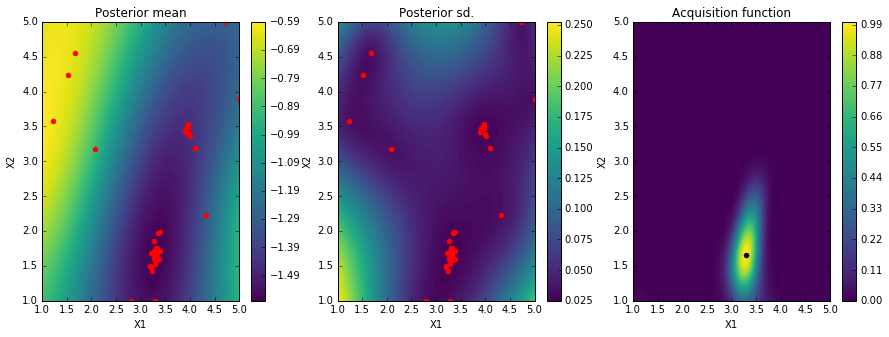

In [35]:
solver.plot_acquisition()

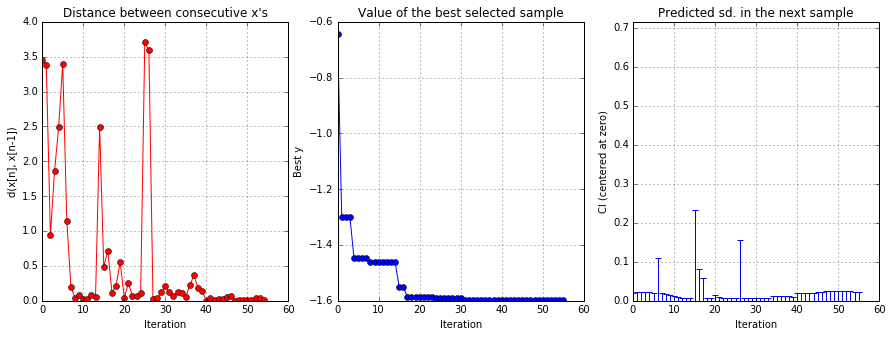

In [36]:
solver.plot_convergence()